In [4]:
import pandas as pd

In [5]:
import matplotlib as plt

## Caterpillar

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
train = pd.read_csv('data/train_set.csv')

In [6]:
submission = pd.read_csv('data/sample_submission.csv')

In [7]:
submission.head()

,id,cost
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [10]:
train.shape

(30213, 8)

In [11]:
train.dtypes

tube_assembly_id       object
supplier               object
quote_date             object
annual_usage            int64
min_order_quantity      int64
bracket_pricing        object
quantity                int64
cost                  float64
dtype: object

In [12]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317
std,1590.331872,12.742776,70.761392,28.663200
min,0.000000,0.000000,1.000000,0.503553
25%,0.000000,0.000000,2.000000,3.878190
50%,0.000000,0.000000,10.000000,6.521146
75%,2.000000,0.000000,40.000000,13.431781
max,150000.000000,535.000000,2500.000000,1000.000000


In [13]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [14]:
result = pd.read_csv('data/sample_submission.csv')

##Modèle quick & Dirty

In [31]:
def parse_0(X):
    target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity']]
    return X, target

In [32]:
#X,y = parse_0(train.copy())

In [33]:
X,y = parse_0(train[train.annual_usage<100000])

In [34]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
lr = LinearRegression()

In [37]:
def rmsle_old(prediction, actual):
    k = 0
    for i in range(len(prediction)):
        k = k + (log(prediction[i]+1)-log(actual[i]+1)) ** 2
    return sqrt(k/len(prediction))

In [38]:
def rmsle(prediction, actual):
    assert len(prediction) == len(actual)
    return np.sqrt(np.mean(np.power(np.log1p(prediction)-np.log1p(actual),2)))

In [39]:
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle)

In [40]:
rmsle(y, [1]*len(y)) #Juste pour tester si rmsle est ok.

1.7174799865252168

In [41]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
lr.coef_

array([-0.00058939, -0.04710658, -0.06774753])

In [43]:
lr.predict(X_test)

array([ 16.07827755,   9.37127173,   9.37127173, ...,  15.80728741,
        14.79048502,  -0.7908583 ])

In [44]:
rmsle(lr.predict(X_test),y_test)

1.2196142455403822

In [45]:
train.bracket_pricing.value_counts()

Yes    26283
No      3930
dtype: int64

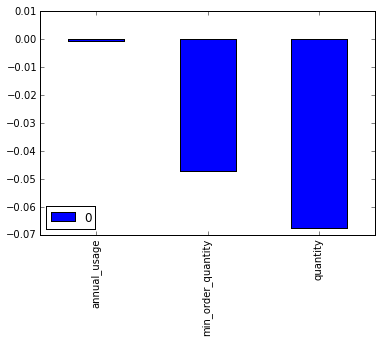

In [46]:
pd.DataFrame(lr.coef_, index=X.columns).plot(kind="bar")

## Générer le submission_set

In [47]:
test = pd.read_csv('data/test_set.csv')

In [48]:
test.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [49]:
X = test[['annual_usage', 'min_order_quantity','quantity']]

In [50]:
preds = pd.DataFrame(lr.predict(X),columns=['cost'])
preds.head()

,cost
0,16.078278
1,16.010530
2,15.807287
3,15.468550
4,14.452337


In [147]:
test.count()

id                    30235
tube_assembly_id      30235
supplier              30235
quote_date            30235
annual_usage          30235
min_order_quantity    30235
bracket_pricing       30235
quantity              30235
dtype: int64

In [51]:
preds["id"] = test.id
preds = preds [["id","cost"]]
preds.head()
preds.cost = preds.cost.clip(0,1000000)

In [52]:
preds.to_csv("data/quickDirtysubmission.csv",index=False)

## Modèle moins dirty 2. Dummyser bracket pricing

In [53]:
def rmsle2(estimator, prediction, actual):
    estimator.predict(
    assert len(prediction) == len(actual)
    return np.sqrt(np.mean(np.power(np.log1p(prediction)-np.log1p(actual),2)))

SyntaxError: invalid syntax (<ipython-input-53-251a25540aa5>, line 3)

In [54]:
def parse_1(X):
    target = pd.DataFrame([])
    if 'cost' in X.columns:
        # si on passe le jeu de test réel, cost n'est pas là
        target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing']]
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X, target

In [55]:
X,y = parse_1(train.copy())

In [56]:
X.head()

,annual_usage,min_order_quantity,quantity,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0,1
1,0,0,2,0,1
2,0,0,5,0,1
3,0,0,10,0,1
4,0,0,25,0,1


## Fonction d'évaluation de modèle

In [57]:
def evaluate_model(evaluator, X,y):
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
    from sklearn.cross_validation import cross_val_score
    print evaluator
    print mean(cross_val_score(evaluator, X, y, rmsle_scorer, cv = 20))
    lr.fit(X_train,y_train)
    pd.DataFrame(lr.coef_, index=X_train.columns).plot(kind="bar")

##### Test de la fonction d'éval de modèle sur une régression linéaire simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.953880900538


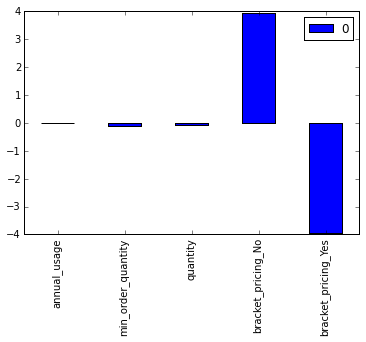

In [58]:
X,y = parse_1(train.copy())
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
evaluate_model(lr,X,y)

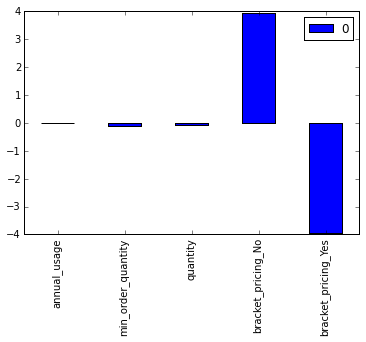

In [60]:
pd.DataFrame(lr.coef_, index=X.columns).plot(kind="bar")

## Industrialisation de la soumission

In [61]:
def submit(X_submit,y_submit):
    ## gènère un fichier submit en mettant à zero tous les costs négatifs
    assert len(X_submit) == len(y_submit)
    from datetime import datetime
    row = datetime.now().strftime('%Y-%m-%d-%H-%M')
    name = 'submit/submit_%s.csv' %row
    idx = test_submit.id.values.astype(int)
    preds = pd.DataFrame({'id':idx, 'cost':y_submit})
    preds = preds[['id','cost']]
    preds.cost = preds.cost.clip(0,1000000)
    preds.to_csv(name,index=False)
    print 'generated '+name

In [62]:
test_submit = pd.read_csv('data/test_set.csv')
# Codage de la matrice X
X_submit,y_drop = parse_1(test_submit)
# Prediction du y sur X
y_submit = lr.predict(X_submit)
# génréation du fichier de submit
submit(test_submit,y_submit)

generated submit/submit_2015-07-17-16-47.csv


In [193]:
train_base = pd.read_csv('data/train_set.csv')
train_br =  train_base[train_base.bracket_pricing=="Yes"]
train_br = train_br[train_br.annual_usage<100000]
train_br.bracket_pricing.value_counts()

Yes    26282
dtype: int64

In [195]:
train_nbr = train_base[train_base.bracket_pricing=="No"]
train_nbr = train_nbr[train_nbr.annual_usage<100000]
train_nbr.bracket_pricing.value_counts()

No    3929
dtype: int64

In [196]:
X,y = parse_1(train_br)

In [200]:
X = X[['annual_usage', 'quantity']]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.953880900538


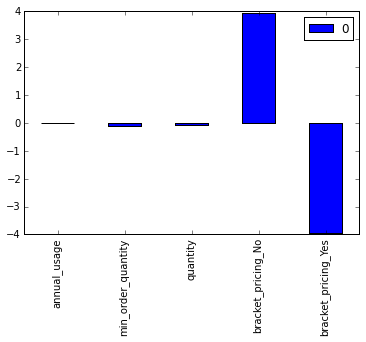

In [63]:
evaluate_model(lr,X,y)

In [64]:
pd.merge(train,tube, on='tube_assembly_id')

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id_x,diameter_x,...,bend_radius_y,end_a_1x_y,end_a_2x_y,end_x_1x_y,end_x_2x_y,end_a_y,end_x_y,num_boss_y,num_bracket_y,other_y
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


## Appliquer un random Forrest

In [65]:
rmsle(train.cost, np.ones(train.shape[0])*train.cost.mean())

0.94748992900412188

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.578232934665


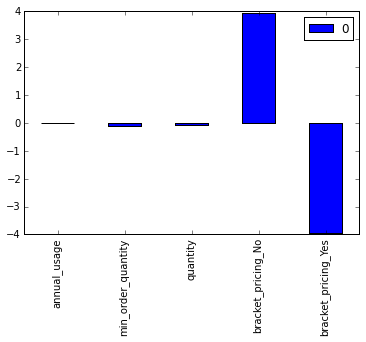

In [66]:
import sklearn.ensemble as en
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
X,y = parse_1(train.copy())
evaluate_model(rf,X,y)

## ajouter des variables par join

In [67]:
train = pd.read_csv('data/train_set.csv',parse_dates=["quote_date"])

In [68]:
def parse_2(X):
    target = pd.DataFrame([])
    if 'cost' in X.columns:
        # si on passe le jeu de test réel, cost n'est pas là
        target = X['cost']
        X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other','year','month']]
    else:
        X = X[['id','annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other','year','month']]
  
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X, target

In [69]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [70]:
tube = pd.read_csv('data/tube.csv')
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [71]:
comp_adaptator = pd.read_csv('data/comp_adaptor.csv')
comp_adaptator.head()

,component_id,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
0,C-0005,CP-028,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
1,C-0006,CP-028,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
2,C-1435,CP-028,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
3,C-1546,CP-028,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
4,C-1583,CP-028,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256


In [72]:
train = pd.merge(train,tube, on='tube_assembly_id')

In [73]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


In [74]:
train["year"] = train.quote_date.map(lambda x: x.year)
train["month"] = train.quote_date.map(lambda x: x.month)

In [75]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,...,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,year,month
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,SP-0019,6.35,...,N,N,N,EF-008,EF-008,0,0,0,2013,7
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,SP-0019,6.35,...,N,N,N,EF-008,EF-008,0,0,0,2013,7
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,SP-0019,6.35,...,N,N,N,EF-008,EF-008,0,0,0,2013,7
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,SP-0019,6.35,...,N,N,N,EF-008,EF-008,0,0,0,2013,7
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,SP-0019,6.35,...,N,N,N,EF-008,EF-008,0,0,0,2013,7


##réappliquer le RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.438237989533


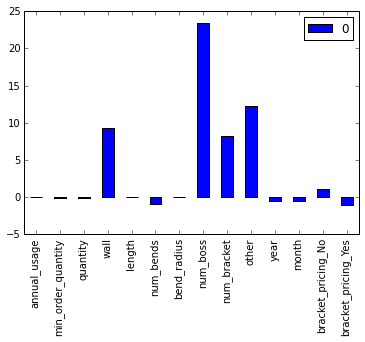

In [76]:
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
X,y = parse_2(train.copy())
evaluate_model(rf,X,y)

### comparer avec une régression linéaire de base

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.850484957799


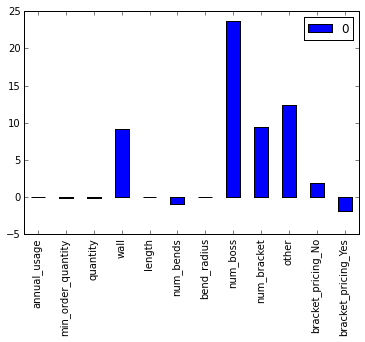

In [328]:
X,y = parse_2(train.copy())
lr = LinearRegression()
evaluate_model(lr,X,y)

## soumission du RF avec matrice joinée sur tube

In [28]:
def parse_3(X):
    print X.columns

    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other','year','month']]
    
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X

In [82]:
test_submit = pd.read_csv('data/test_set.csv',parse_dates=["quote_date"])
test_submit.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [83]:
test_submit = pd.merge(test_submit,tube, on='tube_assembly_id')
test_submit.head()
test_submit["year"] = test_submit.quote_date.map(lambda x: x.year)
test_submit["month"] = test_submit.quote_date.map(lambda x: x.month)

In [84]:
#test_submit = test_submit.drop(['id'],axis=1)
# Codage de la matrice X
X_submit = parse_3(test_submit.copy())
#X_submit2 = X_submit.drop(['id'],axis=1)
# Initialisation et évaluation de la RF
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
#X,y = parse_2(train.copy())
rf.fit(X,y)
#evaluate_model(rf,X_submit,y)
# Prediction du y sur X
y_submit = rf.predict(X_submit)
# génréation du fichier de submit
submit(test_submit,y_submit)

Index([u'id', u'tube_assembly_id', u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity', u'material_id',
       u'diameter', u'wall', u'length', u'num_bends', u'bend_radius',
       u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x', u'end_a', u'end_x',
       u'num_boss', u'num_bracket', u'other', u'year', u'month'],
      dtype='object')
generated submit/submit_2015-07-17-17-02.csv


array([ 26.05002409,  15.56851484,   8.42750421, ...,   3.66086399,
        18.09940332,  36.72943919])

In [316]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [317]:
X.head()

,annual_usage,min_order_quantity,quantity,wall,length,num_bends,bend_radius,num_boss,num_bracket,other,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0.71,137,8,19.05,0,0,0,0,1
1,0,0,2,0.71,137,8,19.05,0,0,0,0,1
2,0,0,5,0.71,137,8,19.05,0,0,0,0,1
3,0,0,10,0.71,137,8,19.05,0,0,0,0,1
4,0,0,25,0.71,137,8,19.05,0,0,0,0,1
